In [63]:
import pandas as pd 
import numpy as np 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from src.files.fasta import FASTAFile
from Bio import Phylo
from itertools import product, combinations
from utils import *
from src.coevolution import get_scores
from scipy.stats import mannwhitneyu
from src.files.itol import *
import io
from src.tree import *  

%load_ext autoreload 
%autoreload 2

palette = {'pyl+':'steelblue', 'pyl-':'gray'}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
arf1_df = load_arf1_dataset(exclude_genome_ids=['GCA_003164755.1'])

print('Num. sequences being discarded which are not in either Pyl+ recoded or Pyl- categories:', (arf1_df.category == 'pyl+').sum())
arf1_df = arf1_df[arf1_df.category != 'pyl+'].copy()
print('Num. potentially-mislabeled Pyl- sequences being discarded:', ((arf1_df.category == 'pyl-') & (arf1_df.tag_percent < 0.05)).sum())
arf1_df = arf1_df[~((arf1_df.category == 'pyl-') & (arf1_df.tag_percent < 0.05))].copy()

min_phylum_size = 10
phylum_counts = arf1_df.phylum.value_counts()
mask = arf1_df.phylum.isin(phylum_counts[phylum_counts >= min_phylum_size].index.values)
print(f'Discarding {(~mask).sum()} sequences from phyla which do not meet the minimum size threshold.')
arf1_df = arf1_df[arf1_df.phylum.isin(phylum_counts[phylum_counts >= min_phylum_size].index.values)].copy()

arf1_df['category'] = arf1_df.category.replace({'pyl+ recoded':'pyl+'})
alignment_df = load_msa('../data/arf1_cleaned.afa', ids=arf1_df.index, conservation_threshold=0.8)

Num. sequences being discarded which are not in either Pyl+ recoded or Pyl- categories: 73
Num. potentially-mislabeled Pyl- sequences being discarded: 11
Discarding 18 sequences from phyla which do not meet the minimum size threshold.


Num phylum: 12
Num class: 44
Num order: 96
Num family: 243
Num genus: 715
Num species: 2386


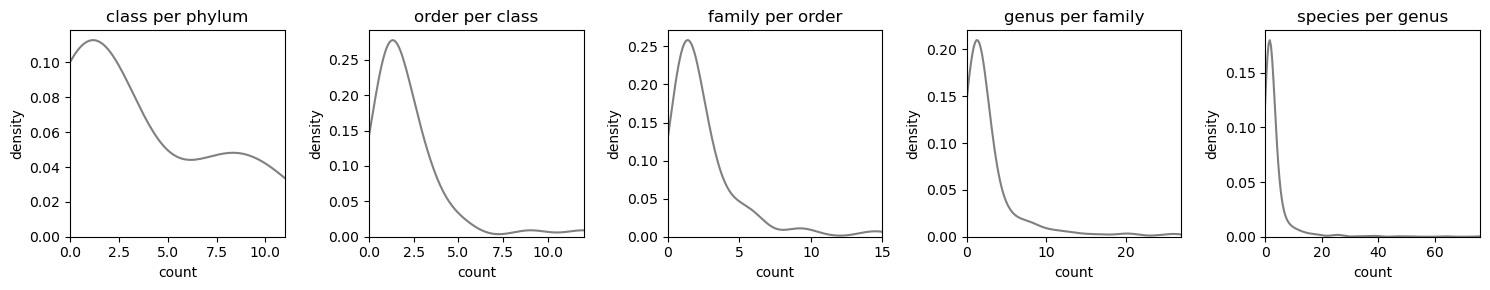

In [65]:
levels = ['phylum', 'class', 'order', 'family', 'genus', 'species']

for level in levels:
    print(f'Num {level}:', arf1_df[level].nunique())

# Confirm that all genuses are homogenous, either all Pyl+ or Pyl-. 
for genus, df in arf1_df.groupby('genus'):
    assert df.category.nunique() == 1, f'The genus {genus} contains both Pyl+ and Pyl- organisms.'

# Look at the distribution of genus sizes. 
fig, axes = plt.subplots(ncols=len(levels) - 1, figsize=(3 * (len(levels) - 1), 3))
for i in range(len(levels) - 1):
    figure_df = pd.DataFrame(arf1_df.drop_duplicates(levels[i + 1])[levels[i]].value_counts())
    sns.kdeplot(figure_df, x='count', color='gray', ax=axes[i])
    axes[i].set_title(f'{levels[i + 1]} per {levels[i]}')
    axes[i].set_xlim(xmin=0, xmax=figure_df['count'].max())
    axes[i].set_ylabel('density')

fig.tight_layout()
plt.show()

In [66]:
def _annotate_residues(annotations:dict, ax=None, lines_only:bool=False):
    for seq, (start, stop) in annotations.items():
        positions = np.arange(start, stop)
        for x, aa in zip(positions, list(seq)):
            if not lines_only:
                ax.text(x, ax.get_ylim()[-1], aa, ha='center', va='bottom')
            ax.axvline(x, ls='--', lw=0.5, color='gray')

alignment_df = load_msa('../data/arf1_cleaned.afa', ids=arf1_df.index, conservation_threshold=0.8)
seq = ''.join(alignment_df.iloc[0])
domain_boundaries = get_domain_boundaries(seq)

get_domain_boundaries: NIKS boundaries 54-58.
get_domain_boundaries: YxCxxxF boundaries 118-125.
get_domain_boundaries: GTS boundaries 22-25.
get_domain_boundaries: GGQ boundaries 176-179.


In [67]:
# Build a matrix for each genus based on the aRF1 MSA, where the columns correspond to the frequency of an amino acid and the rows
# correspond to a position, resulting in a final matrix shape of (416, 20).

aas = 'ACDEFGHIKLMNPQRSTVWY-X' 
aa_idx = {a:i for i, a in enumerate(aas)}

alignment_df = alignment_df.replace(dayhoff)
aas = ''.join(list(dayhoff.values())) + '-X'
aa_idx = {a:i for i, a in enumerate(aas)}

def _get_frequency_matrix(alignment_df:pd.DataFrame):
    alignment = alignment_df[[c for c in alignment_df.columns if isinstance(c, int)]].values
    m = np.zeros((alignment.shape[1], len(aas)), dtype=float)
    for aa in aas:
        m[:, aa_idx[aa]] = np.sum(alignment == aa, axis=0)
    m = m / m.sum(axis=1, keepdims=True)
    return m

def get_frequency_matrix(alignment_df:pd.DataFrame, normalize_levels:str=['order', 'family', 'genus', 'species']):
    # levels = ['phylum', 'class', 'order', 'family', 'genus', 'species']
    levels = [(normalize_levels[i], normalize_levels[i + 1]) for i in range(len(normalize_levels) - 1)][::-1]

    M = {species:_get_frequency_matrix(df) for species, df in alignment_df.groupby('species')}
    for upper_level, lower_level in levels:
        M_ = dict()
        for upper_taxon, df in alignment_df.groupby(upper_level):
            m = np.mean([M[lower_taxon] for lower_taxon in df[lower_level].unique()], axis=0)
            M_[upper_taxon] = m
        M = M_
    M_df = pd.DataFrame(np.mean(list(M.values()), axis=0), columns=list(aas))
    M_df['position'] = M_df.index
    return M_df

levels = ['phylum', 'class', 'order', 'family', 'genus', 'species']

alignment_df[levels] = arf1_df[levels]

orders = ['Methanosarcinales', 'Methanomassiliicoccales']

M_pyl_minus = dict()
M_pyl_plus = dict()

for order in orders:
    M_pyl_minus[order] = get_frequency_matrix(alignment_df[(arf1_df.category == 'pyl-') & (arf1_df.order == order)].copy())
    M_pyl_plus[order] = get_frequency_matrix(alignment_df[(arf1_df.category == 'pyl+') & (arf1_df.order == order)].copy())
M_pyl_minus['all'] = get_frequency_matrix(alignment_df[(arf1_df.category == 'pyl-') & ~arf1_df.order.isin(orders)], normalize_levels=['phylum', 'class', 'order', 'family', 'genus', 'species'])


In [68]:
def get_divergence_scores(M, order:str='Methanosarcinales', intra_order:bool=False):

    scores = np.linalg.norm(M[0].drop(columns=['position']).values - M[1].drop(columns=['position']).values, ord=1, axis=1)
    scores = scores / 2
    score_df = dict()
    score_df['score'] = scores
    score_df['position'] = np.arange(len(scores))
    return pd.DataFrame(score_df)

inter_order_scores = dict()
intra_order_scores = dict()

for order in orders:
    inter_order_scores[order] = get_divergence_scores((M_pyl_plus[order], M_pyl_minus['all']))
    intra_order_scores[order] = get_divergence_scores((M_pyl_plus[order], M_pyl_minus[order]))



Interesting positions for Methanomassiliicoccales: 157, 261
Interesting positions for Methanosarcinales: 81, 88, 155, 265, 290


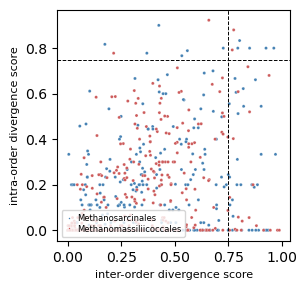

In [81]:
figure_df = pd.concat([df.assign(order=order) for order, df in intra_order_scores.items()])
figure_df = figure_df.rename(columns={'score':'intra_order_score', 'order':'_order', 'position':'_position'})
figure_df = pd.concat([figure_df, pd.concat([df.assign(order=order) for order, df in inter_order_scores.items()])], axis=1)
figure_df = figure_df.rename(columns={'score':'inter_order_score'})

palette = {'Methanomassiliicoccales':'indianred', 'Methanosarcinales':'steelblue'}
fig, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(figure_df, x='inter_order_score', y='intra_order_score', hue='order', palette=palette, s=5, ax=ax)
ax.set_ylabel('intra-order divergence score', fontsize=8)
ax.set_xlabel('inter-order divergence score', fontsize=8)

shrink_legend_scatterplot(ax, loc='lower left')

threshold = 0.75
ax.axvline(threshold, ls='--', lw=0.7, color='black')
ax.axhline(threshold, ls='--', lw=0.7, color='black')

mask = (figure_df.inter_order_score > threshold) & (figure_df.intra_order_score > threshold)
# mask = (figure_df.intra_order_score > 0.9)
for order, df in figure_df[mask].groupby('order'):
    print(f'Interesting positions for {order}:', ', '.join(df.position.astype(str)))
plt.show()

In [70]:
def plot_distribution(figure_df, ax:plt.Axes=None, position:int=None, palette=None, min_frequency:float=0.05):
    figure_df = figure_df[(figure_df.position == position) & (figure_df.frequency > min_frequency)].copy()
    sns.barplot(figure_df, x='residue', y='frequency', hue='category', ax=ax, palette=palette, edgecolor='black', lw=0.5)
    # sns.histplot(figure_df[figure_df[position] != '-'], x=position, hue='category', multiple='dodge', stat=stat, ax=ax, palette=palette, common_norm=False, shrink=0.8, edgecolor='black', lw=0.8)
    shrink_legend_barplot(ax, loc='upper right')
    ax.set_ylabel('probability')
    ax.set_xlabel('')
    ax.set_title(f'position {position}')
    ax.set_ylim(ymin=0, ymax=1)


In [71]:
len([3, 19, 78, 79, 81, 88, 155, 162, 163, 260, 265, 290, 304, 338, 403])

15

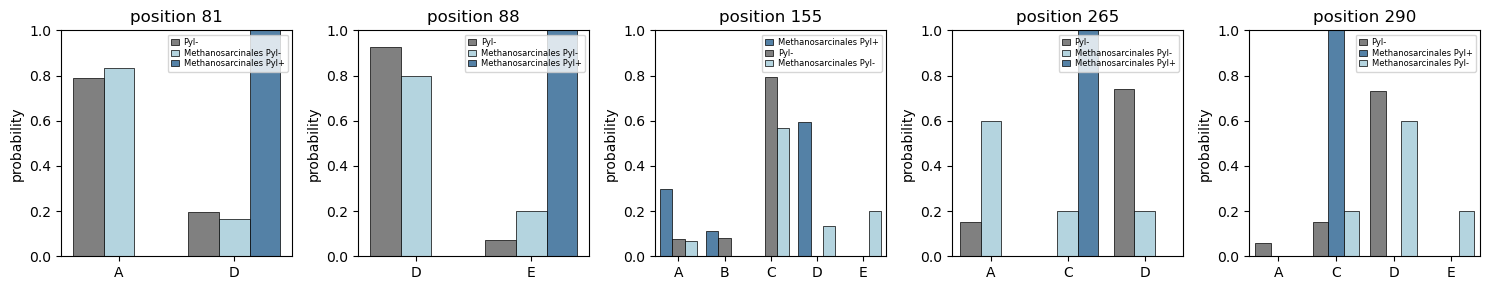

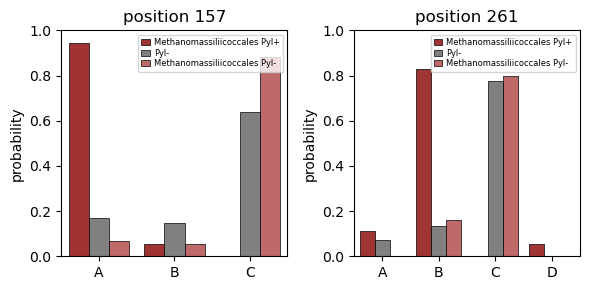

In [82]:

def figure(order:str=None, positions:list=None):

    figure_df = [M_pyl_plus[order].assign(category=f'{order} Pyl+')]
    figure_df += [M_pyl_minus['all'].assign(category=f'Pyl-')]
    figure_df += [M_pyl_minus[order].assign(category=f'{order} Pyl-')]
    figure_df = pd.concat(figure_df)
    figure_df = figure_df.melt(var_name='residue', id_vars=['category', 'position'], value_name='frequency')

    palette = {'Methanosarcinales Pyl+':'steelblue', 'Methanosarcinales Pyl-':'lightblue', 'Pyl-':'gray'}
    palette.update({'Methanomassiliicoccales Pyl+':'firebrick', 'Methanomassiliicoccales Pyl-':'indianred'})

    if len(positions) == 1:
        fig, ax = plt.subplots(figsize=(3, 3))
        axes = [ax]
    else:
        fig, axes = plt.subplots(ncols=len(positions), figsize=(3 * len(positions), 3), sharey=False)

    for position, ax in zip(positions, axes):
        plot_distribution(figure_df, ax=ax, position=position, palette=palette)
    fig.tight_layout()
    plt.show()

# figure(alignment_df, order='Methanosarcinales', positions=[78, 81, 88, 155, 162]) 260, 265, 288, 290, 304, 338, 403
figure(order='Methanosarcinales', positions=[81, 88, 155, 265, 290]) #, 260, 265, 288, 304, 338]) 
figure(order='Methanomassiliicoccales', positions=[157, 261])


In [73]:
# In theory, if a potential mutation is indeed a development which does something to decrease aRF1 functionality or specificity, it should
# be rare elsewhere in the tree (not just within the order). We can then evaluate the likelihood that a candidate mutation is significant by 
# comparing the divergence metric between members of the same order and 

In [74]:
# for order, genome_ids_ in genome_ids.items():
#     arf1_df_ = arf1_df[arf1_df.genome_id.isin(genome_ids_)].copy()
#     alignment_df_ = alignment_df.loc[arf1_df_.index].copy()

#     tree_write(gtdb_load_ar53_tree(genome_ids=genome_ids_), path=f'../data/trees/ar53_{order}.tree')
#     tree_relabel(f'../data/trees/ar53_{order}.tree', f'../data/trees/ar53_{order}_species.tree', label_map={row.genome_id:row.species for row in arf1_df_.itertuples()})






















In [75]:
# def get_residue_distribution(df:pd.DataFrame, position, normalize:bool=True, ignore_gaps:bool=False, as_array:bool=True):

#     n = len([col for col in df.columns if (type(col) == int)]) # Length of the alignment. 
#     df = df[['genus'] + list(range(n))].copy() # Make sure not to include excess columns. 
#     df = df[df[position] != '-'].copy() if ignore_gaps else df.copy()
#     aas = list('ACDEFGHIKLMNPQRSTVWY') if ignore_gaps else list('ACDEFGHIKLMNPQRSTVWY-')

#     n_genuses = df.genus.nunique()
#     # Make sure each genus contributes equally to the final distribution by normalizing the initial count. 
#     df = df.groupby('genus')[position].value_counts(normalize=True).reset_index(name='count')
#     df = pd.DataFrame(df.groupby(position).sum())
#     df['frequency'] = df['count'] / n_genuses if normalize else df['count']
#     distribution = df['frequency'].to_dict()
#     distribution.update({aa:0 for aa in aas if (aa not in distribution)})
#     if as_array:
#         distribution = np.array([distribution[aa] for aa in aas])
#     return distribution

# alignment_df = alignment_df.copy()

# alignment_df['category'] = arf1_df.category 
# alignment_df['order'] = arf1_df.order
# alignment_df['genus'] = arf1_df.genus

In [76]:
# def get_residue_distribution(df:pd.DataFrame, position, normalize:bool=True, ignore_gaps:bool=True):
#     distribution_df = list()

#     df = df[df[position] != '-'].copy() if ignore_gaps else df.copy()
#     aas = list('ACDEFGHIKLMNPQRSTVWY') if ignore_gaps else list('ACDEFGHIKLMNPQRSTVWY-')

#     for category, df_ in df.groupby('category'):
#         n_genuses = df_.genus.nunique()
#         # Make sure each genus contributes equally to the final distribution by normalizing the initial count. 
#         df_ = df_.groupby('genus')[position].value_counts(normalize=True).reset_index(name='count')
#         df_ = pd.DataFrame(df_.groupby(position).sum())
#         df_['frequency'] = df_['count'] / n_genuses if normalize else df['count']
#         # df_ = df_.set_index(position) # The position column is the amino acid value. 
#         row = df_['frequency'].to_dict()
#         row.update({aa:0 for aa in aas if (aa not in row)})
#         row.update({'category':category})
#         distribution_df.append(row)

#     distribution_df = pd.DataFrame(distribution_df)
#     distribution_df['position'] = position 
#     return distribution_df